# Tutorial for `bajes.inf` analysis

The model to be inferred is defined by two key ingredients:
* the prior distribution of the employed parameters 
* the likelihood function that describe the capability to fit the data

Using the default `bajes` routine, we can define the prior parameters using a configuration file.
Each section corresponds to a single parameter, where the title is the name of the parameter and the arguments are the following:
* `max`: upper bound (mandatory)
* `min`: lower bound (mandatory)
* `periodic`: periodic (1) or reflective (0) bounds (default 0)
* `prior`: string that specify the prior distribution for the parameter (default `uniform`), the available options are 
    * `uniform`
    * `log-uniform`
    * `linear`
    * `quadratic`
    * `cosinusoidal`
    * `sinusoidal`
    * `power-law` (requires `deg`)
    * `triangular` (requires `mode`)
    * `exponential` (requires `tau`)
    * `normal` (requires `mu` and `sigma`)
    * `custom`, the code will look in the `like.py` file for a `log_prior_{parameter-name}` method

In our example, we use a 3-dimensional parameter space, such that: `x1` is uniformly distributed, `x2` is distributed according with a power law with `deg=0.5` and `x3` has a customized prior

In [1]:
prior_file = open('./prior.ini', 'w')
prior_file.write("""
[x1]
min   = -10
max   = 10

[x2]
min   = 0.
max   = 10
prior = power-law
deg   = 0.5 

[x3]
min   = -10
max   = 10
prior = custom
""")
prior_file.close()

Then, we need to define the likelihood function in an external Python file, i.e. `like.py`. This allows the user to load, define and employ arbitrary data and objects. 

The likelihood file `like.py` should contain a method called `log_like` where the argument is a dictionary `params`, where the keys are defined by the parameters names.

In [2]:
like_file = open('./like.py', 'w')
like_file.write("""
import numpy as np

def log_prior_x3(x):
    return np.log(np.abs(x))

def log_like(p):
    vr = 0.1
    r1 = np.sqrt(p['x1']**2. + (p['x2']-2.)**2.)
    r2 = np.sqrt(p['x1']**2. + (p['x2']+2.)**2.)
    return np.log(np.exp(-0.5*(r1 - 2.)**2/vr) + np.exp(-0.5*(r2 - 2.)**2/vr)) - 0.5*p['x3']**2./vr
""")
like_file.close()

Once the model is formulated, it is possible to execute a parameter estimation job running the string

    python -m bajes -p prior.ini -l like.py -o ./outdir/ -n 4
    
The primary flags are:
* `-p`: path to prior file
* `-l`: path to likelihood file
* `-o`: path to output directory
* `-n`: number of parallel processes (default serial)
* `-s`: string specifying sampler engine (mcmc, ptmcmc, nest, cpnest, dynest)
* `-v`: verbose

See `python -m bajes --help` for the full list of arguments.

In [12]:
from bajes.utils import execute_bash

command = "python -m bajes -p prior.ini -l like.py -o ./outdir/ -n 4"
execute_bash(command)

This command will take some time to complete the execution. Verbose option `-v` is suggested if the user wants to overview the status of jobs while it is running.

The posterior samples can be found at `outdir/posterior.dat`, together with the `bajes.log` file, that contains the logged information of the executed job. The `bajes.log` looks like

    INFO [DD-MM-YYYY hh:mm:ss]: > bajes, Bayesian Jenaer Software
    INFO [DD-MM-YYYY hh:mm:ss]: * VERSION : X.Y.Z
    INFO [DD-MM-YYYY hh:mm:ss]: * PATH    : /path/to/bajes
    INFO [DD-MM-YYYY hh:mm:ss]: * GITHASH : abcdefghijk0123456789lmnopqrstuvwxyz0123
    INFO [DD-MM-YYYY hh:mm:ss]: * ENGINE  : NEST
    INFO [DD-MM-YYYY hh:mm:ss]: * PROCS   : 4
    INFO [DD-MM-YYYY hh:mm:ss]: Importing likelihood module ...
    INFO [DD-MM-YYYY hh:mm:ss]: Parsing prior options ...
    INFO [DD-MM-YYYY hh:mm:ss]: Setting x1 with uniform prior in range [-10,10] ...
    INFO [DD-MM-YYYY hh:mm:ss]: Setting x2 with power-law prior in range [0,10]...
    INFO [DD-MM-YYYY hh:mm:ss]: Setting x3 with custom prior in range [-10,10]...
    INFO [DD-MM-YYYY hh:mm:ss]: Initializing prior distribution ...
    INFO [DD-MM-YYYY hh:mm:ss]: Initializing parallel pool ...
    INFO [DD-MM-YYYY hh:mm:ss]: Initializing sampler ...
    INFO [DD-MM-YYYY hh:mm:ss]: Disabling checkpoint ...
    INFO [DD-MM-YYYY hh:mm:ss]: Initializing proposal methods ...
    INFO [DD-MM-YYYY hh:mm:ss]: Extracting prior samples ...
    INFO [DD-MM-YYYY hh:mm:ss]: Initializing nested sampler ...
    INFO [DD-MM-YYYY hh:mm:ss]: Running 1024 live points ...

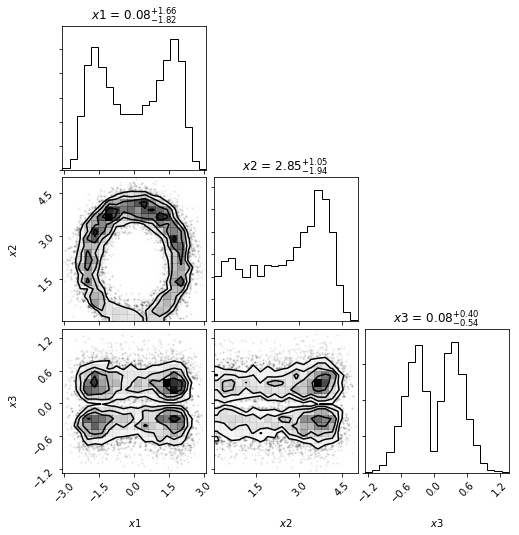

In [7]:
# here we resort to corner to show the results
import numpy as np
import corner

posterior_file = './outdir/posterior.dat'
posterior      = np.genfromtxt(posterior_file, names=True)

fig = corner.corner(np.vstack([posterior['x1'], posterior['x2'], posterior['x3']]).T, 
                  labels=[r"$x1$", r"$x2$", r"$x3$"], show_titles=True, title_kwargs={"fontsize": 12})